### 1. Importing libraries

In [1]:
try:
    import pandas as pd
    import numpy as np
    import geemap, ee
    import matplotlib.pyplot as plt
    import seaborn as sns
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()) :
        print("Package not found, installing w/ pip in Google Colab...");
        %pip install geemap
    else :
        print("Package not found, installing w/ conda...")
        %conda install mamba -c conda-forge -y
        %mamba install geemap -c conda-forge-y
        %conda install pandas -c conda-forge-y
        %conda install numpy -c conda-forge-y
        %conda install matplotlib -c conda-forge-y
        %conda install seaborn -c conda-forge-y
        
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geemap, ee

In [2]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

### 2. Initialize Variable

In [3]:
#Initialize VIIRS
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").filterDate('2019-06-01', '2022-06-01')

#Jakarta Longitude, lattitude, and point of interest with 500m buffer
lon = 106.8166
lat = -6.2088
buffer = 500 #500m areas

poi = ee.Geometry.Point(lon, lat).buffer(buffer)

### 3. Get time-series data

In [4]:
#get POI mean and date from image (VIIRS as source)
scaleFactor = 30

def get_poi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=scaleFactor, maxPixels=1e9).get('avg_rad')
    return img.set('date', img.date().format()).set('mean', mean)

#Get reduced image colletion
poi_reduced = viirs.map(get_poi_mean)

#Reduced image collection to list
key_cols = ['date', 'mean']

reduced_list = poi_reduced.reduceColumns(ee.Reducer.toList(len(key_cols)), key_cols).values().get(0)

#List to dataframe
df = pd.DataFrame(reduced_list.getInfo(), columns=key_cols)

#Convert date to datetime and index
df['date'] = pd.to_datetime(df['date'])
df.set_index("date", inplace=True)
df.tail(5)

,mean
date,
2022-01-01,45.702835
2022-02-01,41.888474
2022-03-01,102.712744
2022-04-01,59.736578
2022-05-01,61.304639


<AxesSubplot:xlabel='date', ylabel='mean'>

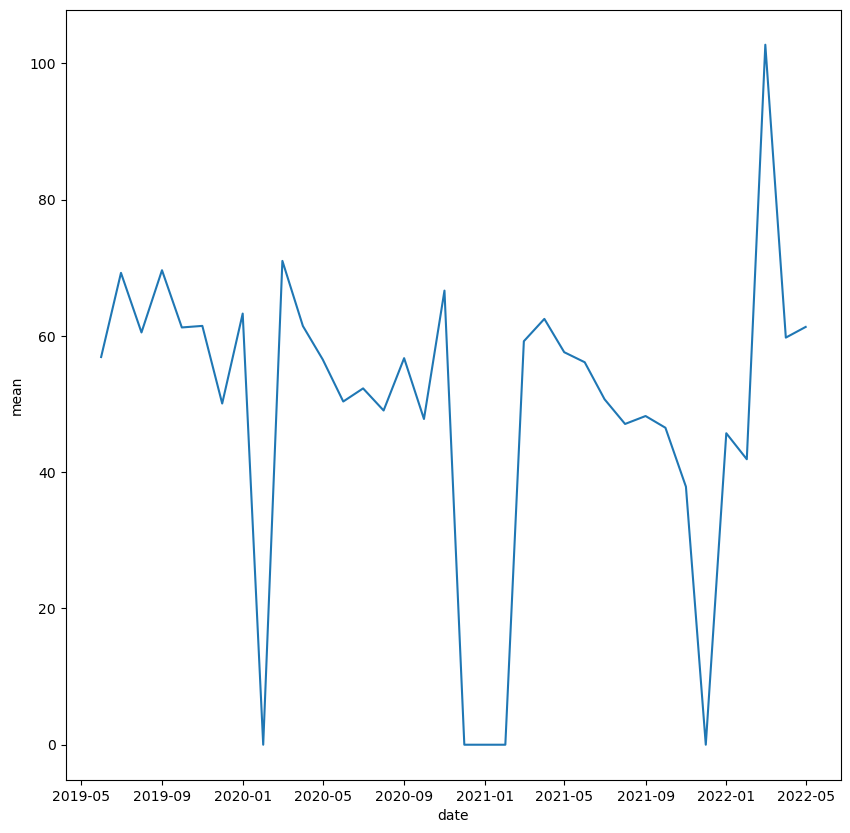

In [5]:
#Visualize the data

window = 3

fig, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(data=df, x=df.index, y="mean", ax=ax)

### 3. Get rate of change

In [6]:
first_img = viirs.sort('system:time_end').first()
last_img = viirs.sort('system:time_end', False).first()

periods = int(viirs.size().getInfo())

#Function to get slope (rate of change)
def get_slope(first_img, last_img):
    return (last_img.select('avg_rad').subtract(first_img.select('avg_rad'))).divide(periods)

#VIIRS with rate of change
viirs_slope = get_slope(first_img, last_img)

In [7]:
viirs_map = geemap.Map(center=[lat, lon], zoom=10)

params = {'min' : -1,
          'max' : 1,
          'palette':['1d4877','1b8a5a','f68838','ee3e32']}

# viirs_map.add_basemap('SATELLITE')
viirs_map.addLayer(viirs_slope, params, '2019 - 2022 VIIRS-DNB monthy rate of change', opacity=0.7)
viirs_map.addLayerControl()
viirs_map

Map(center=[-6.2088, 106.8166], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

### 3. Visualize Data

In [8]:
#Compare first and last

left_layer = geemap.ee_tile_layer(first_img.select('avg_rad'), {}, 'VIIRS-DNB 2019', opacity=0.75)
right_layer = geemap.ee_tile_layer(last_img.select('avg_rad'), {}, 'VIIRS-DNB 2022', opacity=0.75)

map = geemap.Map(center=[lat, lon], zoom=8)
map.add_basemap('SATELLITE')
map.split_map(left_layer= left_layer, right_layer= right_layer)
map.addLayerControl()
map

Map(center=[-6.2088, 106.8166], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

### Get Median of specific coordinate

In [9]:
df = pd.read_csv("/Users/arya/Documents/Anaconda/Night Light/mall_v2.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,Nama Mall,Nama Perusahaan,Alamat Lokasi Usaha,Wilayah,lat,long
0,0,0,Mal Taman Anggrek,PT. Mulia Intipelangi,"Jl. Letjen. S Parman Kav. 1, Slipi",Jakarta Barat,-6.178375,106.792276
1,1,1,ITC Roxy Mas,PT. Jakarta Sinar Intertrade,"Jl. Mangga Dua Raya, Jkt14430",Jakarta Barat,-6.166694,106.803037
2,3,3,Lindeteves Trade Centre,PT. Citra Gemilang Nusantara,Jl. Hayam Wuruk 127 Jakarta barat 11180,Jakarta Barat,-6.146412,106.816351
3,4,4,Seasons City,PT. Cakrawira Bumimandala,Prof. Dr. Latumenten No. 33,Jakarta Barat,-6.153106,106.795376
4,5,5,Central Park,PT. Tiara Metropolitan Jaya,Jl. S. Parman Kav. 29,Jakarta Barat,40.782773,-73.965363


In [10]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").filterDate('2019-01-01', '2022-12-31')

def get_dates(img):
    return img.set('date', img.date().format())

dates = viirs.map(get_dates)
dates_list = dates.reduceColumns(ee.Reducer.toList(1), ['date']).values()
dates = pd.to_datetime(np.asarray(dates_list.getInfo()).squeeze(), utc=False).astype(str)

cols_length = len(dates)
median_cols = np.array(dates)

cols_length

42

In [11]:
scaleFactor = 100

def coordinate_to_median(x, buffer=500):
    poi = ee.Geometry.Point(x['long'], x['lat']).buffer(buffer)   

    def get_poi_median(img):
        median = img.reduceRegion(
                reducer=ee.Reducer.median(), 
                geometry=poi, 
                scale=scaleFactor,
                maxPixels=1e9).get('avg_rad')

        return img.set('date', img.date().format()).set('median', median)

    poi_reduced = viirs.map(get_poi_median)
    median_list = poi_reduced.reduceColumns(ee.Reducer.toList(1), ['median']).values()
    median_list = np.asarray(median_list.getInfo()).squeeze()

    # median_df = median_df.append(median_list, ignore_index=True)
    return median_list

df = df.dropna()
median_list = df.apply(coordinate_to_median, axis=1)

    
median_list

0     [55.849998474121094, 53.79999923706055, 54.540...
1     [46.34000015258789, 43.0, 0.0, 46.200000762939...
2     [57.84000015258789, 51.790000915527344, 33.840...
3     [44.869998931884766, 39.349998474121094, 23.45...
4     [42.209999084472656, 44.54999923706055, 47.680...
                            ...                        
57    [40.02000045776367, 39.2599983215332, 41.25999...
58    [57.439998626708984, 48.22999954223633, 26.090...
59    [1.0399999618530273, 1.0399999618530273, 0.930...
60    [53.560001373291016, 57.77000045776367, 42.200...
61    [58.29999923706055, 40.349998474121094, 19.379...
Length: 62, dtype: object

In [12]:
# median_df = pd.DataFrame(data=median_list[0:, 0:], index=[i for i in range(len(median_list[0]))], columns=median_cols)
# median_df.head()
data = [median_cols, *median_list]
data = np.array(data)

median_df = pd.DataFrame(data=data[1:,1:], columns=data[0,1:])  
median_df.head(10)

,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,...,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01
0,53.799999,54.540001,52.16,55.919998,43.060001,51.580002,43.279999,47.619999,45.23,43.459999,...,36.299999,43.619999,33.740002,0.0,42.110001,24.059999,37.049999,58.16,43.040001,0.0
1,43.0,0.0,46.200001,45.630001,42.099998,44.610001,37.919998,42.27,40.889999,37.330002,...,36.110001,37.560001,30.040001,33.07,36.040001,37.459999,29.08,38.98,32.880001,29.110001
2,51.790001,33.84,55.209999,58.139999,55.509998,68.129997,49.080002,49.689999,49.48,44.259998,...,36.529999,38.43,59.48,0.0,48.84,58.869999,63.82,53.639999,43.75,28.860001
3,39.349998,23.459999,34.380001,40.150002,37.580002,39.540001,35.049999,37.07,37.529999,33.099998,...,28.200001,35.07,0.0,0.0,35.369999,29.1,32.169998,41.290001,31.42,26.940001
4,44.549999,47.68,31.33,0.0,0.0,0.0,29.049999,43.639999,26.549999,34.060001,...,28.34,26.040001,30.83,32.09,65.43,49.52,30.93,34.389999,0.0,0.0
5,43.759998,33.84,44.040001,50.93,46.68,51.66,43.529999,43.650002,45.450001,41.240002,...,33.779999,38.919998,33.27,0.0,41.279999,41.59,40.139999,40.389999,43.09,21.07
6,54.07,45.75,39.389999,53.130001,50.310001,43.540001,36.48,45.049999,42.889999,40.630001,...,37.09,45.130001,44.560001,0.0,40.959999,45.200001,49.240002,44.040001,49.560001,52.27
7,18.07,15.7,26.200001,20.799999,20.33,19.280001,22.6,22.6,20.51,19.040001,...,21.0,17.139999,5.61,17.629999,0.0,38.700001,17.99,17.030001,26.57,13.79
8,8.03,10.07,10.93,9.84,9.27,10.26,10.56,11.31,10.86,11.71,...,9.98,9.88,11.22,0.0,8.78,6.26,11.86,14.47,8.97,10.97
9,38.439999,35.5,47.099998,51.52,44.32,46.490002,37.150002,44.549999,48.290001,43.950001,...,38.450001,37.860001,34.450001,0.0,34.299999,29.57,39.490002,40.259998,37.290001,27.91


In [13]:
#Merging data 

df_merged = df.join(median_df)
df_merged

,Unnamed: 0.1,Unnamed: 0,Nama Mall,Nama Perusahaan,Alamat Lokasi Usaha,Wilayah,lat,long,2019-02-01,2019-03-01,...,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01
0,0,0,Mal Taman Anggrek,PT. Mulia Intipelangi,"Jl. Letjen. S Parman Kav. 1, Slipi",Jakarta Barat,-6.178375,106.792276,53.799999,54.540001,...,36.299999,43.619999,33.740002,0.0,42.110001,24.059999,37.049999,58.16,43.040001,0.0
1,1,1,ITC Roxy Mas,PT. Jakarta Sinar Intertrade,"Jl. Mangga Dua Raya, Jkt14430",Jakarta Barat,-6.166694,106.803037,43.0,0.0,...,36.110001,37.560001,30.040001,33.07,36.040001,37.459999,29.08,38.98,32.880001,29.110001
2,3,3,Lindeteves Trade Centre,PT. Citra Gemilang Nusantara,Jl. Hayam Wuruk 127 Jakarta barat 11180,Jakarta Barat,-6.146412,106.816351,51.790001,33.84,...,36.529999,38.43,59.48,0.0,48.84,58.869999,63.82,53.639999,43.75,28.860001
3,4,4,Seasons City,PT. Cakrawira Bumimandala,Prof. Dr. Latumenten No. 33,Jakarta Barat,-6.153106,106.795376,39.349998,23.459999,...,28.200001,35.07,0.0,0.0,35.369999,29.1,32.169998,41.290001,31.42,26.940001
4,5,5,Central Park,PT. Tiara Metropolitan Jaya,Jl. S. Parman Kav. 29,Jakarta Barat,40.782773,-73.965363,44.549999,47.68,...,28.34,26.040001,30.83,32.09,65.43,49.52,30.93,34.389999,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,76,76,Sport Mall,PT. Gamma Investa Lestari,Jl. Raya Kelapa Nias Blok HF No. 3,Jakarta Utara,17.080411,-96.710913,39.259998,41.259998,...,35.220001,40.73,41.689999,47.75,42.799999,39.290001,46.610001,38.299999,28.17,27.059999
58,77,77,Pluit Junction,PT. Jakarta Management Estatindo,Jl. Pluit raya No. 1,Jakarta Utara,-6.126030,106.791276,48.23,26.09,...,34.400002,44.740002,52.970001,45.950001,49.639999,0.0,40.169998,36.34,36.459999,28.42
59,79,79,La Piazza,PT. Sumarecon Agung tbk,Jl. Bolevar Kelapa gading Blok M,Jakarta Utara,43.529933,11.285106,1.04,0.93,...,1.14,1.25,1.05,1.17,1.03,1.07,1.29,1.1,0.0,0.0
60,81,81,WTC Mangga Dua,PT. Cipta Karya Bukit Indah,"Jl. Mangga Dua Raya No. 8,",Jakarta Utara,-6.133728,106.830675,57.77,42.200001,...,37.0,36.220001,40.360001,0.0,35.98,40.380001,52.02,0.0,39.82,30.860001


In [15]:
df_merged.to_csv('mall_v2.csv')